# SARIMA Models - Lab

## Introduction

In this lesson, we'll reiterate what you learned previously, and talk about **integrated** models (hence ARIMA, which means **integrated** ARMA), and extend to models that can cope with seasonality of time series.

## Objectives

In this lab you will: 

- Preprocess a dataset to meet ARIMA based forecasting assumptions 
- Identify best model parameters using grid search for p, d, q and seasonal p, d, q parameters 
- Describe the components of an ARIMA model 
- Create visualizations of future values as well as confidence intervals for the future predictions 
- Evaluate an ARIMA model with validation testing 
- Explain how validation testing is different with time series data than normal data 


## ARIMA

Time series provide the opportunity to predict/forecast future values based on previous values. Such analyses can be used to forecast trends in economics, weather, and capacity planning etc. The specific properties of time series data mean that specialized statistical methods are usually required.

So far, we have seen different techniques to make time series stationary, as well as white noise, moving average, AR, MA and ARMA models. Now recall that your data needs to be detrended (or made **stationary**) before you can go along and use ARMA models. This is because it is easier to add trends and seasonality back in after you modeled your data. Now there are several issues with ARMA:

- ARMA models assume that the detrending already happened
- ARMA neglects that seasonality can happen

Let's summarize what we can observe when having time series in three situations:

1. A strictly stationary series with no dependence among the values. This is the easy case wherein we can model the residuals as white noise. But this is very rare.

2. A non-stationary series with significant dependence among values, but no seasonality. In this case we can use ARMA models after we have detrended, or we can use an **integrated** ARMA model that detrends for us.

3. A non-stationary series with significant dependence among values, **and** seasonality. In this case we can use a seasonal arima or SARIMA model.

In this tutorial, we aim to produce reliable forecasts of a given time series by applying one of the most commonly used method for time series forecasting: ARIMA. After that we'll talk about seasonality and how to cope with it. 

One of the methods available in Python to model and predict future points of a time series is known as SARIMAX, which stands for **Seasonal AutoRegressive Integrated Moving Averages with eXogenous regressors**. Here, we will primarily focus on the **ARIMA** component, which is used to fit time series data to better understand and forecast future points in the time series.

## Dataset

For this lab you will use the dataset that we have seen before - "Atmospheric CO2 from Continuous Air Samples at Mauna Loa Observatory, Hawaii, U.S.A.," which collected CO2 samples from March 1958 to December 2001. Let's bring in this data and plot as demonstrated earlier. You will need to perform following tasks: 

- Import necessary libraries
- Import the CO2 dataset from `statsmodels` 
- Ensure that the type of the column representing the dates is correct and set it as the index of the DataFrame 
- Resample the data as monthly groups and take monthly average
- Fill in the missing values using the `.fillna()` and `.bfill()` methods 
- Inspect the first few rows of the data 
- Plot the time series of data 

In [2]:
# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
plt.style.use('ggplot')

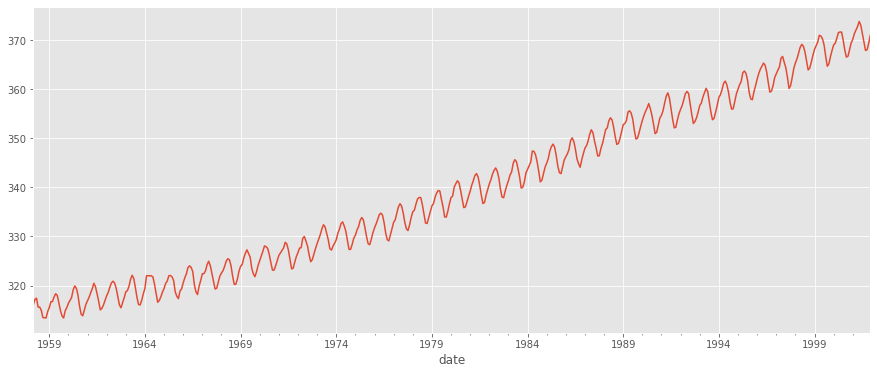

date
1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
Freq: MS, Name: co2, dtype: float64


In [8]:
# Load the dataset
dataset = sm.datasets.co2.load().data

# Convert into DataFrame
df = pd.DataFrame(dataset)

# Update to datetime type
df['date'] = pd.to_datetime(df['index'])

# Set as index
df.set_index(df['date'], inplace=True)

df.drop(['date', 'index'], axis=1, inplace=True)
## https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
df = df.asfreq('W-SAT')
df
# The 'MS' string groups the data in buckets by start of the month
CO2 = df['co2'].resample('MS').mean()

# The term bfill means that we use the value before filling in missing values
CO2 = CO2.fillna(CO2.bfill())

# Plot the time series
CO2.plot(figsize=(15, 6))
plt.show()
print(CO2.head())

As noted earlier, the time series has spikes reflecting an obvious seasonality pattern, as well as an overall increasing trend.

## The ARIMA Time Series Model

One of the most common methods used in time series forecasting is known as the ARIMA model, which stands for **AutoregRessive Integrated Moving Average**. ARIMA is a model that can be fitted to time series data in order to better understand or predict future points in the series.

Let's have a quick introduction to ARIMA. The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters (p,d,q) of the ARIMA model:

### Number of AR (Auto-Regressive) terms (p) 

`p` is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to rain tomorrow if it has been raining for past 3 days. AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

### Number of Differences (d) 

`d` is the **Integrated** component of an ARIMA model. This value is concerned with the amount of differencing as it identifies the number of lag values to subtract from the current observation. Intuitively, this would be similar to stating that it is likely to rain tomorrow if the difference in amount of rain in the last *n* days is small. 

### Number of MA (Moving Average) terms (q)  

`q` is the moving average part of the model which is used to set the error of the model as a linear combination of the error values observed at previous time points in the past. MA terms form lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where `e(i)` is the difference between the moving average at ith instant and actual value.

These three distinct integer values, (p, d, q), are used to parametrize ARIMA models. Because of that, ARIMA models are denoted with the notation `ARIMA(p, d, q)`. Together these three parameters account for seasonality, trend, and noise in datasets:

* `(p, d, q)` are the non-seasonal parameters described above.
* `(P, D, Q)` follow the same definition but are applied to the seasonal component of the time series. 
* The term `s` is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.).

A detailed article on these parameters is available [here](https://www.quantstart.com/articles/Autoregressive-Integrated-Moving-Average-ARIMA-p-d-q-Models-for-Time-Series-Analysis).

The seasonal ARIMA method can appear daunting because of the multiple tuning parameters involved. We will now describe how to automate the process of identifying the optimal set of parameters for the seasonal ARIMA time series model.

## Parameter Selection for the ARIMA Time Series Model 

The first step towards fitting an ARIMA model is to find the values of `ARIMA(p,d,q)(P,D,Q)s` that produce the desired output. Selection of these parameters requires domain expertise and time.  We shall first generate small ranges of these parameters and use a "grid search" to iteratively explore different combinations of parameters. For each combination of parameters, we fit a new seasonal ARIMA model with the `SARIMAX()` function from the `statsmodels` library and assess its overall quality. 

`SARIMAX` detailed documentation can be viewed [here](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html)

Let's begin by generating example combination of parameters that we wish to use: 

- Define p, q, and d parameters to take any value from 0/1 using `range()` function. (Note: We can try larger values which can make our model computationally expensive to run, you can try this as an additional experiment) 
- Generate combinations for `(p,d,q)` using `itertools.product`  
- Similarly, generate seasonal combinations as `(p,d,q)s`. Use s = 12 (constant) 
- Print some example combinations for seasonal ARIMA  

In [9]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

## AIC (Akaike Information Criterion) as Regularization Measure


For evaluating the model, we shall use the AIC (Akaike Information Criterion) value, which is provided by ARIMA models fitted using `statsmodels` library. The Akaike information criterion (AIC) is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. Thus, AIC provides a means for model selection. 

A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value. To achieve this, perform following tasks:

- Initialize an empty list to store results 
- Iterate through all the paramaters in `pdq` with parameters in seasonal `pdq` (nested loop ) to create a grid 
- Run `SARIMAX` from `statsmodels` for each iteration. Details can be found [here](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html). Set `enforce_stationarity` and `enforce_invertibility` to False  
- Get the results in each iteration with `model.fit()` and store the AIC values 
- Find the lowest AIC and select parameters for further analysis  

NOTE: 
* Integrate exception handling with `continue`  
* An overview of Akaike Information Criterion can be viewed [here](http://www.statisticshowto.com/akaikes-information-criterion/) 

In [10]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(CO2,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.23439D+00    |proj g|=  7.60014D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   7.600D-07   7.234D+00
  F =   7.2343948953241553     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =7612.583429881011
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0    

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  6.68945D+00    |proj g|=  5.51113D-01

At iterate   15    f=  6.44805D+00    |proj g|=  2.96602D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     17     30      1     0     0   1.241D-05   6.448D+00
  F =   6.4480452699890360     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =6787.343624028466
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.76139D+00    |proj g|=  1.67403D-02


 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.51399D+00    |proj g|=  3.00343D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     11      1     0     0   4.398D-07   1.514D+00
  F =   1.5139840045287762     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =1596.7111727642725
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00279D+00    |proj g|=  1.23380D+00

           * * *

Tit   = total number of iterations
Tnf   =

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00474D+00    |proj g|=  1.83808D+01

At iterate    5    f=  1.00373D+00    |proj g|=  1.57826D+01

At iterate   10    f=  9.99143D-01    |proj g|=  2.79266D+00

At iterate   15    f=  9.99122D-01    |proj g|=  6.58352D-01

At iterate   20    f=  9.98505D-01    |proj g|=  2.85704D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     47      1     0     0   4.322D-02   9.984D-01
  F =  0.99837248611040408     

CONVERG


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.06258D+00    |proj g|=  6.84048D-01

At iterate   10    f=  9.89322D-01    |proj g|=  2.27672D-01

At iterate   15    f=  9.87419D-01    |proj g|=  5.32277D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     24      1     0     0   5.323D-05   9.874D-01
  F =  0.98741900312434727     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =1044.7647912868133
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   15    f=  6.57056D+00    |proj g|=  4.25797D-01

At iterate   20    f=  6.54059D+00    |proj g|=  1.76873D-01

At iterate   25    f=  6.53712D+00    |proj g|=  1.34234D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     25     62      1     0     0   1.342D-04   6.537D+00
  F =   6.5371185879706699     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =6881.048754545145
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  6.64698D+00    |proj g|=  8.76742D-02

At iterate   10    f=  6.61982D+00    |proj g|=  2.62308D-03

At iterate   15    f=  6.61727D+00    |proj g|=  3.24500D-02

At iterate   20    f=  6.46299D+00    |proj g|=  5.84665D-01

At iterate   25    f=  5.78647D+00    |proj g|=  3.85617D-01

At iterate   30    f=  5.76679D+00    |proj g|=  1.99812D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     31     60      1     0     0   5.289D-05   5.767D+00
  F =   5.7667892852243758     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.17437D+00    |proj g|=  6.70049D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     13      1     0     0   1.327D-06   1.174D+00
  F =   1.1743512088268258     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =1241.4174716858206
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.88954D+00    |proj g|=  7.21398D-01


 This problem is unconstrained.



At iterate    5    f=  6.58167D+00    |proj g|=  1.31028D-02

At iterate   10    f=  6.57879D+00    |proj g|=  1.21370D-01

At iterate   15    f=  4.71747D+00    |proj g|=  1.17834D+02
  ys=-2.066E+00  -gs= 6.934E-01 BFGS update SKIPPED

At iterate   20    f=  2.35693D+00    |proj g|=  4.10014D+01

At iterate   25    f=  1.65999D+00    |proj g|=  5.26618D+01

At iterate   30    f=  1.30831D+00    |proj g|=  2.81554D+00

At iterate   35    f=  1.13301D+00    |proj g|=  1.22979D+00

At iterate   40    f=  1.07155D+00    |proj g|=  2.78696D+01

At iterate   45    f=  1.04093D+00    |proj g|=  1.83027D+01

At iterate   50    f=  1.02650D+00    |proj g|=  3.11852D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =1085.8729879342918
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.86304D+00    |proj g|=  7.18444D-01

At iterate    5    f=  6.56200D+00    |proj g|=  2.51632D-02

At iterate   10    f=  6.53258D+00    |proj g|=  3.34480D-02

At iterate   15    f=  6.52694D+00    |proj g|=  1.09373D-01

At iterate   20    f=  4.49686D+00    |proj g|=  8.77514D+00

At iterate   25    f=  2.63612D+00    |proj g|=  1.29219D+01

At iterate   30    f=  1.20920D+00    |proj g|=  1.27619D+01

At iterate   35    f=  7.70678D-01    |proj g|=  2.41362D+01

At iterate   40    f=  7.36277D-01    |proj g|=  7.20619D-01

At iterate   45    f=  7.34510D-01    |proj g|=  6.01017D+00

At iterate   50    f=  7.34253D-01    |proj g|=  7.22215D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of fu

/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =780.4341510779991
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.36095D+00    |proj g|=  4.76093D-01

At iterate    5    f=  1.05857D+00    |proj g|=  5.86789D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     12      1     0     0   2.572D-06   1.059D+00
  F =   1.0585511305737154     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated =1119.59578

 This problem is unconstrained.



At iterate    5    f=  8.24063D-01    |proj g|=  2.82786D-01

At iterate   10    f=  7.62223D-01    |proj g|=  1.24089D-01

At iterate   15    f=  7.59593D-01    |proj g|=  2.14369D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     31      1     0     0   4.475D-06   7.596D-01
  F =  0.75959248942431756     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated =807.0912988743821
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.00406D-01    |proj g|=  5.95692D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      6      1     0     0   7.298D-05   6.002D-01
  F =  0.60023056912347161     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =633.4425587178921
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0    

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.17359D-01    |proj g|=  5.15443D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     17      1     0     0   1.690D-05   3.173D-01
  F =  0.31729453891457993     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =337.7938549381381
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.85504D-01    |proj g|=  6.19423D-05

           * * *

Tit   = total number of iterations
Tnf   = 

 This problem is unconstrained.
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated =619.9501757813175
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.89392D-01    |proj g|=  9.68475D-01

At iterate    5    f=  3.65263D-01    |proj g|=  1.43788D+00

At iterate   10    f=  3.52599D-01    |proj g|=  5.71705D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     24      1     0     0   6.825D-05   3.526D-01
  F =  0.35259351327334565     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.


ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =478.3296906728358
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.62371D-01    |proj g|=  2.18976D-01

At iterate    5    f=  3.17964D-01    |proj g|=  2.58435D-01

At iterate   10    f=  3.01923D-01    |proj g|=  1.47943D+00
  ys=-1.060E-02  -gs= 9.554E-05 BFGS update SKIPPED

At iterate   15    f=  3.01640D-01    |proj g|=  3.60155D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     51      1     1     0   8.

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.04167D+00    |proj g|=  1.98752D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     15      1     0     0   1.988D-06   1.042D+00
  F =   1.0416740241732567     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated =1101.841073430266
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.56081D-01    |proj g|=  8.47704D-02

At iterate    5    f=  5.55084D-01    |proj g|=  1.05761D-06


 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.85305D-01    |proj g|=  3.64854D-01

At iterate   10    f=  2.81840D-01    |proj g|=  1.42500D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     33      1     0     0   7.909D-05   2.818D-01
  F =  0.28183925852852371     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =302.4948999720069
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.37809D+00    |proj g|=  2.28191D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  5.49842D-01    |proj g|=  6.59452D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     18      1     0     0   6.595D-06   5.498D-01
  F =  0.54984159059820836     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated =584.4333533093152
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24872D+00    |proj g|=  2.24405D+00

At iterate    5    f=  6.90114D-01    |proj g|=  3.51920D+00


 This problem is unconstrained.



At iterate   10    f=  3.74006D-01    |proj g|=  2.47323D-01

At iterate   15    f=  3.27918D-01    |proj g|=  4.03576D-01

At iterate   20    f=  3.12928D-01    |proj g|=  1.08108D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     32      1     0     0   4.092D-04   3.129D-01
  F =  0.31292766655369564     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =337.1999052144878
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate   10    f=  4.05976D-01    |proj g|=  9.95015D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     16      1     0     0   9.950D-07   4.060D-01
  F =  0.40597562813989740     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =433.08636080317206
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.53731D-01    |proj g|=  8.34383D-01


 This problem is unconstrained.



At iterate    5    f=  2.80420D-01    |proj g|=  4.65724D-01

At iterate   10    f=  2.62224D-01    |proj g|=  2.51625D-02
  ys=-4.429E-03  -gs= 1.826E-04 BFGS update SKIPPED

At iterate   15    f=  2.60035D-01    |proj g|=  7.45495D-03

At iterate   20    f=  2.60013D-01    |proj g|=  1.39111D-01

At iterate   25    f=  2.59999D-01    |proj g|=  1.74461D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     63      1     1     0   2.563D-04   2.600D-01
  F =  0.25999906661204752     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =281.51901

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.39003D+00    |proj g|=  1.82242D+01

At iterate   10    f=  1.37228D+00    |proj g|=  4.66014D-01

At iterate   15    f=  1.36633D+00    |proj g|=  6.95249D+00
  ys=-8.900E-02  -gs= 5.312E-02 BFGS update SKIPPED

At iterate   20    f=  1.18202D+00    |proj g|=  1.02018D+00

At iterate   25    f=  1.17484D+00    |proj g|=  1.37223D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28     47      1     1     0   7.902D-06   1.175D+00
  F =   1.1748436016634412     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =1241.9354

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.48215D-01    |proj g|=  4.08302D-01

At iterate   10    f=  3.18782D-01    |proj g|=  2.80144D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     24      1     0     0   9.489D-06   3.187D-01
  F =  0.31871640821972730     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =341.2896614471531
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13553D+00    |proj g|=  7.02833D-01


 This problem is unconstrained.



At iterate   15    f=  5.45047D-01    |proj g|=  7.58829D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     34      1     0     0   7.588D-02   5.450D-01
  F =  0.54504719131445500     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =579.3896452628067
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12698D+00    |proj g|=  7.17839D-01

At iterate    5    f=  5.00409D-01    |proj g|=  4.01450D-01


 This problem is unconstrained.



At iterate   10    f=  4.60735D-01    |proj g|=  5.95025D+00

At iterate   15    f=  4.35541D-01    |proj g|=  1.82087D+00

At iterate   20    f=  4.35206D-01    |proj g|=  8.95201D-01

At iterate   25    f=  3.78007D-01    |proj g|=  1.87420D+01

At iterate   30    f=  3.44677D-01    |proj g|=  3.22458D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     91      2     0     0   4.209D-02   3.447D-01
  F =  0.34466904012739824     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =370.59183021402293
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12946D+00    |proj g|=  2.49999D+00

At iterate    5    f=  4.96574D-01    |proj g|=  1.57807D+00

At iterate   10    f=  4.46816D-01    |proj g|=  2.96614D-04

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     17      1     0     0   7.217D-06   4.468D-01
  F =  0.44681563005767122     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =476.0500428206701
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.04621D-01    |proj g|=  4.54003D-01


 This problem is unconstrained.



At iterate    5    f=  4.39836D-01    |proj g|=  1.23645D+00

At iterate   10    f=  3.12449D-01    |proj g|=  7.58128D-01

At iterate   15    f=  3.05691D-01    |proj g|=  1.67250D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     35      1     0     0   1.081D-03   3.057D-01
  F =  0.30568868456219944     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =329.5844961594338
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     42      1     0     0   6.888D-02   1.299D+00
  F =   1.2990575933117485     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =1372.6085881639594
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.24590D+00    |proj g|=  1.24549D+00

At iterate    5    f=  1.67252D+00    |proj g|=  1.02538D+02

At iterate   10    f=  1.13950D+00    |proj g|=  3.86321D+00


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     54      1     0     0   8.218D-02   1.133D+00
  F =   1.1325939379625274     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =1199.4888227365789
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.53171D-01    |proj g|=  4.79431D-02

At iterate    5    f=  5.51757D-01    |proj g|=  2.17052D-03

           * * *

Tit   = total number of iterations
Tnf   =

 This problem is unconstrained.



At iterate   20    f=  5.74006D-01    |proj g|=  3.87013D-01

At iterate   25    f=  5.65500D-01    |proj g|=  2.06286D+00

At iterate   30    f=  5.59670D-01    |proj g|=  2.70364D+00

At iterate   35    f=  5.55079D-01    |proj g|=  1.84321D+00

At iterate   40    f=  5.51898D-01    |proj g|=  1.86102D+00

At iterate   45    f=  5.50253D-01    |proj g|=  9.77551D-01

At iterate   50    f=  5.49060D-01    |proj g|=  1.39815D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     72      1     0     0   1.398D+00   5.491D-01
  F =  0.54906043616104494     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   10    f=  8.69775D-01    |proj g|=  4.70764D+00

At iterate   15    f=  5.56941D-01    |proj g|=  3.82708D+01

At iterate   20    f=  5.37955D-01    |proj g|=  3.75032D-01

At iterate   25    f=  4.41524D-01    |proj g|=  9.89958D+00

At iterate   30    f=  3.91888D-01    |proj g|=  3.10894D+00

At iterate   35    f=  3.70591D-01    |proj g|=  2.90500D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     69      1     0     0   1.912D-01   3.703D-01
  F =  0.37026737429733153     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated 

 This problem is unconstrained.



At iterate    5    f=  5.84924D-01    |proj g|=  1.58175D+00

At iterate   10    f=  4.09387D-01    |proj g|=  8.36513D-02

At iterate   15    f=  4.04513D-01    |proj g|=  2.30217D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     23      1     0     0   2.853D-05   4.045D-01
  F =  0.40451230652012371     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated =433.54694645917016
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

 This problem is unconstrained.



At iterate    5    f=  4.23348D-01    |proj g|=  1.40144D+00

At iterate   10    f=  2.69705D-01    |proj g|=  2.50411D-01

At iterate   15    f=  2.62234D-01    |proj g|=  1.30681D-02

At iterate   20    f=  2.62195D-01    |proj g|=  1.31365D-02

At iterate   25    f=  2.62134D-01    |proj g|=  4.74384D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     41      1     0     0   2.256D-04   2.621D-01
  F =  0.26213420288259520     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated =285.7651814324902
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated =1060.935191443299
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.67245D-01    |proj g|=  5.93865D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     21      1     0     0   5.939D-05   5.672D-01
  F =  0.56724455159091725     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =600.7412682736449
RUNNING THE L-BFGS-B CODE

           * * *

Machine p

 This problem is unconstrained.
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  2.91949D-01    |proj g|=  1.46844D-01

At iterate   10    f=  2.91003D-01    |proj g|=  2.82558D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     20      1     0     0   1.122D-05   2.910D-01
  F =  0.29100091571861231     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =312.13296333598015
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.73905D-01    |proj g|=  5.91869D-01

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.05532D-01    |proj g|=  7.73894D-01

At iterate    5    f=  5.59751D-01    |proj g|=  7.47596D-01

At iterate   10    f=  3.25656D-01    |proj g|=  1.81496D-01

At iterate   15    f=  3.24361D-01    |proj g|=  2.27951D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     33      1     0     0   3.608D-04   3.243D-01
  F =  0.32434329660959743     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1

 This problem is unconstrained.



At iterate    5    f=  4.12687D-01    |proj g|=  1.06133D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     15      1     0     0   2.663D-05   4.127D-01
  F =  0.41267831596285437     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =440.1375883929228
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.71434D-01    |proj g|=  8.61170D-01


 This problem is unconstrained.



At iterate    5    f=  2.88784D-01    |proj g|=  2.03586D-01

At iterate   10    f=  2.71849D-01    |proj g|=  6.65136D-02

At iterate   15    f=  2.71624D-01    |proj g|=  3.03127D-03

At iterate   20    f=  2.71618D-01    |proj g|=  6.04772D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     32      1     0     0   6.048D-05   2.716D-01
  F =  0.27161846225567826     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =293.7426222929735
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =     

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.92474D-01    |proj g|=  2.76232D-03

At iterate   10    f=  9.92456D-01    |proj g|=  1.13089D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     15      1     0     0   3.483D-07   9.925D-01
  F =  0.99245596236306188     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated =1052.0636724059411
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.47111D-01    |proj g|=  6.20430D-02

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =581.3099934822465
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46058D-01    |proj g|=  8.49032D-01

At iterate    5    f=  2.77559D-01    |proj g|=  3.74675D-01

At iterate   10    f=  2.73914D-01    |proj g|=  9.30376D-03

At iterate   15    f=  2.73705D-01    |proj g|=  1.73537D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     23      1     0     0   1.781D-05   2.737D-01
  F =  0.27370475836340030     


 This problem is unconstrained.



At iterate    5    f=  5.62406D-01    |proj g|=  6.08372D-01

At iterate   10    f=  5.47159D-01    |proj g|=  5.87856D-02

At iterate   15    f=  5.40897D-01    |proj g|=  4.26017D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     27      1     0     0   1.481D-05   5.407D-01
  F =  0.54074592317516879     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated =576.8647111802776
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  5.20417D-01    |proj g|=  1.01641D+00

At iterate   10    f=  3.12277D-01    |proj g|=  3.72352D-01

At iterate   15    f=  3.11090D-01    |proj g|=  3.98985D-01

At iterate   20    f=  3.07718D-01    |proj g|=  1.19969D+00

At iterate   25    f=  3.02193D-01    |proj g|=  5.47222D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     42      1     0     0   2.623D-03   3.022D-01
  F =  0.30219097673741391     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =327.9049075277594
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =444.1243686520917
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.49067D-01    |proj g|=  8.40987D-01


 This problem is unconstrained.



At iterate    5    f=  2.76116D-01    |proj g|=  4.65682D-01

At iterate   10    f=  2.57264D-01    |proj g|=  2.41848D-02

At iterate   15    f=  2.54554D-01    |proj g|=  4.93038D-03

At iterate   20    f=  2.54548D-01    |proj g|=  4.45411D-03

At iterate   25    f=  2.54544D-01    |proj g|=  5.21735D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     45      1     0     0   3.098D-06   2.545D-01
  F =  0.25454393535950653     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =277.7802199982009


In [11]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic         277.78022
Name: 63, dtype: object

The output of our code suggests that `ARIMA(1, 1, 1)x(1, 1, 1, 12)` yields the lowest AIC value of `277.78`. We should therefore consider this to be optimal option out of all the models we have considered.

## Fitting an ARIMA Time Series Model

Using grid search, we have identified the set of parameters that produces the best fitting model to our time series data. We can proceed to analyze this particular model in more depth.

We'll start by plugging the optimal parameter values into a new SARIMAX model.

In [12]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(CO2, 
                                        order=(1, 1, 1), 
                                        seasonal_order=(1, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.49067D-01    |proj g|=  8.40987D-01


 This problem is unconstrained.



At iterate    5    f=  2.76116D-01    |proj g|=  4.65682D-01

At iterate   10    f=  2.57264D-01    |proj g|=  2.41848D-02

At iterate   15    f=  2.54554D-01    |proj g|=  4.93038D-03

At iterate   20    f=  2.54548D-01    |proj g|=  4.45411D-03

At iterate   25    f=  2.54544D-01    |proj g|=  5.21735D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     45      1     0     0   3.098D-06   2.545D-01
  F =  0.25454393535950653     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------

The model returns a lot of information, but we'll focus only on the table of coefficients. The `coef` column above shows the importance of each feature and how each one impacts the time series patterns.  The $P>|z|$ provides  the significance of each feature weight. 

For our time-series, we see that each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.

Next, we shall run model diagnostics to ensure that none of the assumptions made by the model have been violated. 

Call the `.plot_diagnostics()` method on ARIMA output below:

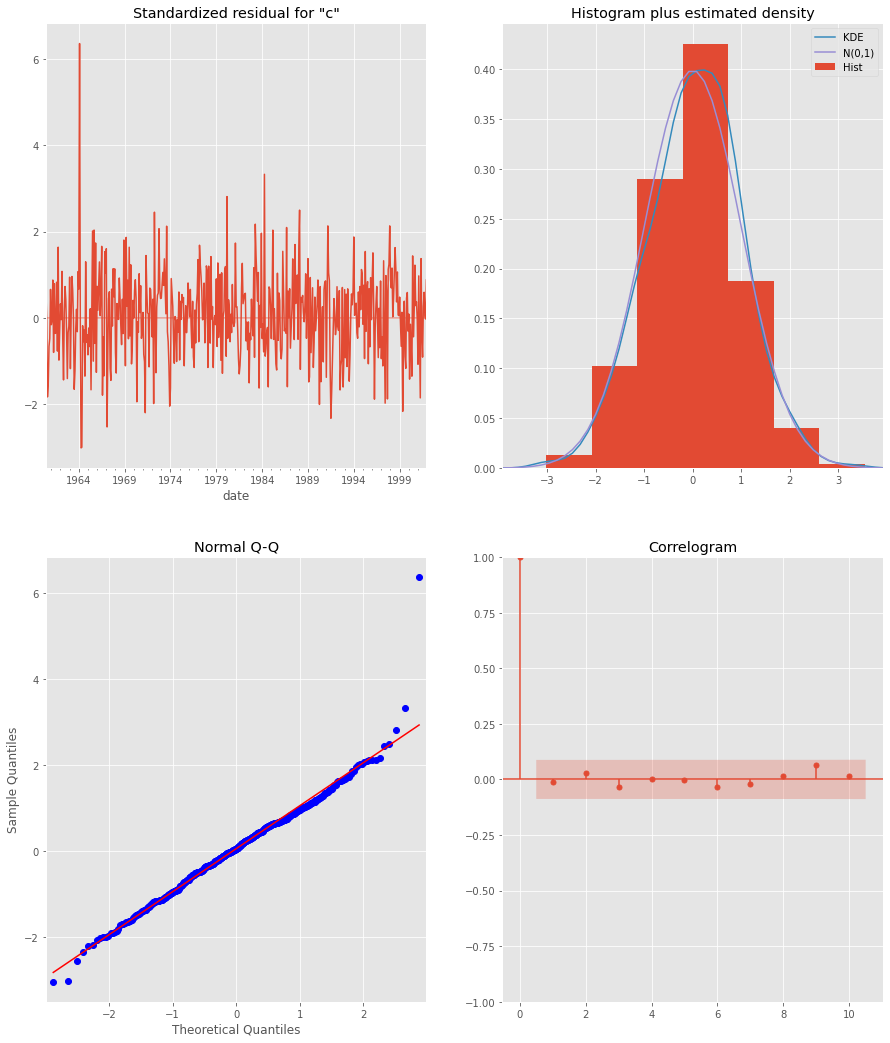

In [14]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

The purpose here is to ensure that residuals remain uncorrelated, normally distributed having zero mean. In the absence of these assumptions, we can not move forward and need further tweaking of the model. 

Let's check for these assumptions from diagnostics plots.

* In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.

* The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.

* The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

These observations lead us to conclude that our model has no correlations and provides a satisfactory fit to help forecast future values.

## Validating the Model

### One-step Ahead Forecasting

In order to validate the model, we start by comparing predicted values to real values of the time series, which will help us understand the accuracy of our forecasts. 

The `.get_prediction()` and `.conf_int()` methods allow us to obtain the values and associated confidence intervals for forecasts of the time series.


- [Documentation on `get_prediction()`](http://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.get_prediction.html)

- [Documentation on `conf_int()`](http://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.conf_int.html)


In the cell below: 

* Get the predictions from 1st January 1998 till 2002 (end of time series) 

* Get the confidence intervals for all predictions 

* For `get_predictions()`, set the `dynamic` parameter to False to ensure that we produce one-step ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point 

In [15]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)
pred_conf = pred.conf_int()

We shall now plot the real and forecasted values of the CO2 time series to assess how well we did: 

* Plot the observed values from the dataset, starting at 1990 
* Use `.predicted_mean.plot()` method to plot predictions 
* Plot the confidence intervals overlapping the predicted values 

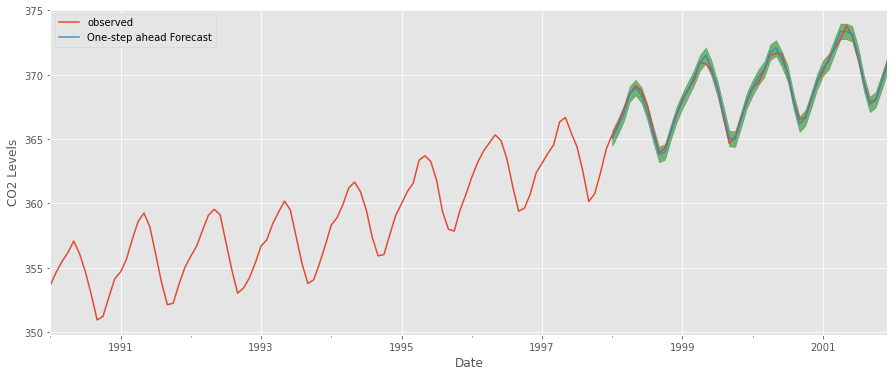

In [16]:
# Plot real vs predicted values along with confidence interval
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = CO2['1990':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()

The forecasts align with the true values  as seen above, with overall increase trend. We shall also check for the accuracy of our forecasts using  **MSE (Mean Squared Error)**. This will provide us with the average error of our forecasts. For each predicted value, we compute its distance to the true value and square the result. The results need to be squared so that positive/negative differences do not cancel each other out when we compute the overall mean.

In [17]:
# Get the real and predicted values
CO2_forecasted = pred.predicted_mean
CO2_truth = CO2['1998-01-01':]

# Compute the mean square error
mse = ((CO2_forecasted - CO2_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.07


The MSE of our one-step ahead forecasts yields a value of 0.07, which is very low. An MSE this close to 0 indicates that the estimator is predicting observations of the parameter with perfect accuracy, which would be an ideal scenario but it is not typically possible.

### Dynamic Forecasting

We can achieve a deeper insight into model's predictive power using dynamic forecasts. In this case, we only use information from the time series up to a certain point, and after that, forecasts are generated using values from previous forecasted time points.

Repeat above calculation for predictions post 1998. Use Dynamic forecasting by setting `dynamic` to True.

In [18]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

Plotting the observed and forecasted values of the time series, we see that the overall forecasts are accurate even when using dynamic forecasts. All forecasted values (red line) match pretty closely to the ground truth (blue line), and are well within the confidence intervals of our forecast.

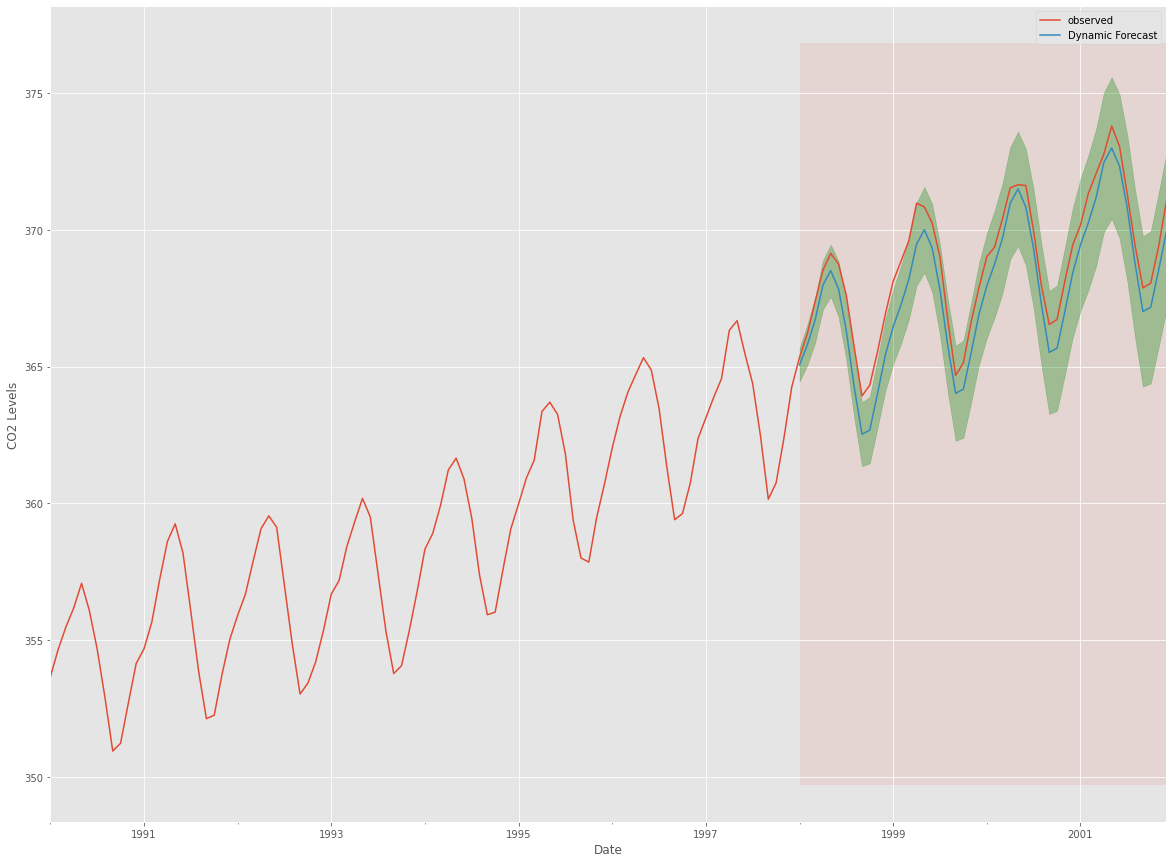

In [19]:
# Plot the dynamic forecast with confidence intervals as above
ax = CO2['1990':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), CO2_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

Once again, we quantify the predictive performance of our forecasts by computing the MSE.

In [20]:
# Extract the predicted and true values of our time series
CO2_forecasted = pred_dynamic.predicted_mean
CO2_truth = CO2['1998-01-01':]

# Compute the mean square error
mse = ((CO2_forecasted - CO2_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1.01


The predicted values obtained from the dynamic forecasts yield an MSE of 1.01. This is slightly higher than the one-step ahead, which is to be expected given that we are relying on less historical data from the time series.

Both the one-step ahead and dynamic forecasts confirm that this time series model is valid. However, much of the interest around time series forecasting is the ability to forecast future values way ahead in time.


## Producing and Visualizing Forecasts

We will now describe how to leverage our seasonal ARIMA time series model to forecast future values. The `.get_forecast()` method of our time series output can compute forecasted values for a specified number of steps ahead.

In [21]:
# Get forecast 500 steps ahead in future
prediction = output.get_forecast(steps=500)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

We can use the output of this code to plot the time series and forecasts of its future values.



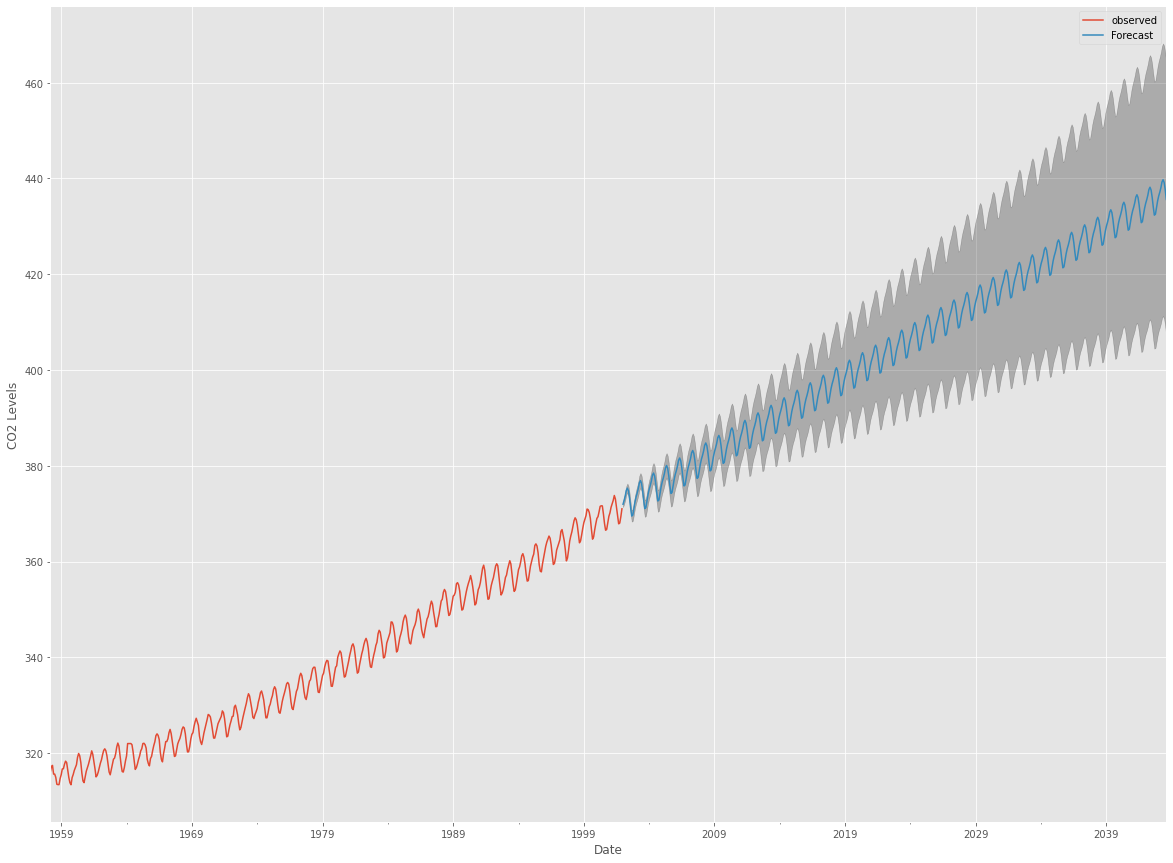

In [22]:
# Plot future predictions with confidence intervals
ax = CO2.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

Both the forecasts and associated confidence interval that we have generated can now be used to further understand the time series and foresee what to expect. Our forecasts show that the time series is expected to continue increasing at a steady pace.

As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future. 

## Bonus Exercises

* Change the start date of your dynamic forecasts to see how this affects the overall quality of your forecasts.
* Try more combinations of parameters to see if you can improve the goodness-of-fit of your model.
* Select a different metric to select the best model. For example, we used the AIC measure to find the best model, but you could seek to optimize the out-of-sample mean square error instead.


## Summary

In this lab, we described how to implement a seasonal ARIMA model in Python. We made extensive use of the `pandas` and `statsmodels` libraries and showed how to run model diagnostics, as well as how to produce forecasts of time series.